In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
#Clear any previous models
tf.keras.backend.clear_session()
#Create directories for saving images
os.makedirs('images', exist_ok=True)

In [2]:
#Load and preprocess MNIST data
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  #Normalize to [-1, 1]
X_train = X_train.reshape(60000, 784)  #Flatten to 784 pixels

#Set random dimension for noise input
randomDim = 100

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print("Building Generator...")
#Build Generator - takes random noise vector (100-dim) as input
#and outputs a flattened MNIST-like image (784-dim)
generator = Sequential([
    #First hidden layer: fully connected with 256 neurons
    Dense(256, input_shape=(randomDim,)),
    #LeakyReLU activation (slope=0.2 for negative values) for stability
    LeakyReLU(0.2),

    #Second hidden layer: 512 neurons
    Dense(512),
    LeakyReLU(0.2),

    #Third hidden layer: 1024 neurons
    Dense(1024),
    LeakyReLU(0.2),

    #Output layer: 784 neurons (28x28 pixels flattened),
    #using 'tanh' so outputs are scaled to [-1, 1],
    #which matches the normalized MNIST dataset
    Dense(784, activation='tanh')
], name='generator')


print("Building Discriminator...")
#Build Discriminator - takes an image vector (784-dim) as input
#and outputs a single probability (real vs fake)
discriminator = Sequential([
    #First hidden layer: 1024 neurons, expects input of size 784
    Dense(1024, input_shape=(784,)),
    LeakyReLU(0.2),
    #Dropout to reduce overfitting and stabilize GAN training
    Dropout(0.3),

    #Second hidden layer: 512 neurons
    Dense(512),
    LeakyReLU(0.2),
    Dropout(0.3),

    #Third hidden layer: 256 neurons
    Dense(256),
    LeakyReLU(0.2),
    Dropout(0.3),

    #Output layer: 1 neuron with sigmoid activation,
    #producing probability of input being "real"
    Dense(1, activation='sigmoid')
], name='discriminator')


print("Generator summary:")
#Prints architecture and parameter count for generator
generator.summary()

print("\nDiscriminator summary:")
#Prints architecture and parameter count for discriminator
discriminator.summary()

#Compile discriminator with binary crossentropy loss
#and Adam optimizer (lr=0.0002, beta1=0.5),
#which is a standard GAN setup
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

Building Generator...
Building Discriminator...
Generator summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
print("Building combined GAN...")
#To train the Generator, we build a combined model:
#  Noise (randomDim) → Generator → Discriminator → Probability
#The Discriminator is frozen (non-trainable) so only the Generator updates
discriminator.trainable = False

#Define GAN input: random noise vector
gan_input = Input(shape=(randomDim,))

#Pass noise through generator to produce a fake image
generated_image = generator(gan_input)

#Pass generated image through discriminator to get real/fake probability
gan_output = discriminator(generated_image)

#Define GAN model: input = noise, output = discriminator’s decision
gan = Model(inputs=gan_input, outputs=gan_output, name='gan')

#Compile with binary crossentropy loss + Adam optimizer
#This ensures that during training, the generator learns to "fool" the discriminator
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

print("GAN summary:")
#Prints the architecture: Noise → Generator → Discriminator
gan.summary()


#Lists to store loss history for plotting later
dLosses = []  #Discriminator losses
gLosses = []  #Generator losses

#Helper function: Save generated images during training
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    #Generate random noise
    noise = np.random.normal(0, 1, size=[examples, randomDim])

    #Use generator to create fake images
    generatedImages = generator.predict(noise)

    #Reshape to 28x28 for visualization
    generatedImages = generatedImages.reshape(examples, 28, 28)

    #Plot grid of generated images
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

    #Save to file (organized by epoch)
    plt.savefig(f'images/gan_generated_image_epoch_{epoch}.png')
    plt.show()

#Helper function: Plot training losses
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminator loss')
    plt.plot(gLosses, label='Generator loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'images/gan_loss_epoch_{epoch}.png')
    plt.show()


#Training function
def train(epochs=1, batchSize=128):
    #Number of batches per epoch
    batchCount = int(X_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    #Loop through epochs
    for e in range(1, epochs + 1):
        print('-' * 15, f'Epoch {e}', '-' * 15)

        #Loop through all batches
        for batch_idx in range(batchCount):
            #Train Discriminator
            #Sample random noise and real images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            #Generate fake images from noise
            generatedImages = generator.predict(noise, verbose=0)

            #Combine real + fake images
            X = np.concatenate([imageBatch, generatedImages])

            #Labels: real = 0.9 (smoothed), fake = 0
            yDis = np.zeros(2 * batchSize)
            yDis[:batchSize] = 0.9  #one-sided label smoothing

            #Train discriminator on real+fake data
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            #Train Generator
            #New random noise
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])

            #Labels are "real" (1) because generator wants to fool discriminator
            yGen = np.ones(batchSize)

            #Freeze discriminator during generator training
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

            #Print batch progress every 100 batches
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}/{batchCount}: "
                      f"D loss: {dloss:.4f}, G loss: {gloss:.4f}")

        #End of epoch: store losses
        dLosses.append(dloss)
        gLosses.append(gloss)

        print(f"Epoch {e} completed: "
              f"Discriminator Loss: {dloss:.4f}, Generator Loss: {gloss:.4f}")

        #Save sample images every 20 epochs (and on epoch 1)
        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)

        #Plot loss curves every 50 epochs
        if e % 50 == 0:
            plotLoss(e)

Building combined GAN...
GAN summary:


Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Sequential)          │ (None, 784)            │     1,486,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Sequential)      │ (None, 1)              │     1,460,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,946,577 (11.24 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 1,460,225 (5.57 MB)


Testing model structure...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Test successful! Generated image shape: (1, 784), Discrimination output: [[0.5196224]]

Starting GAN training...
Epochs: 100
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
Batch 0/468: D loss: 0.6439, G loss: 0.7102
Batch 100/468: D loss: 0.6157, G loss: 0.9196
Batch 200/468: D loss: 0.5779, G loss: 1.0119
Batch 300/468: D loss: 0.5371, G loss: 1.2097
Batch 400/468: D loss: 0.5253, G loss: 1.3262
Epoch 1 completed: Discriminator Loss: 0.5247, Generator Loss: 1.3826
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


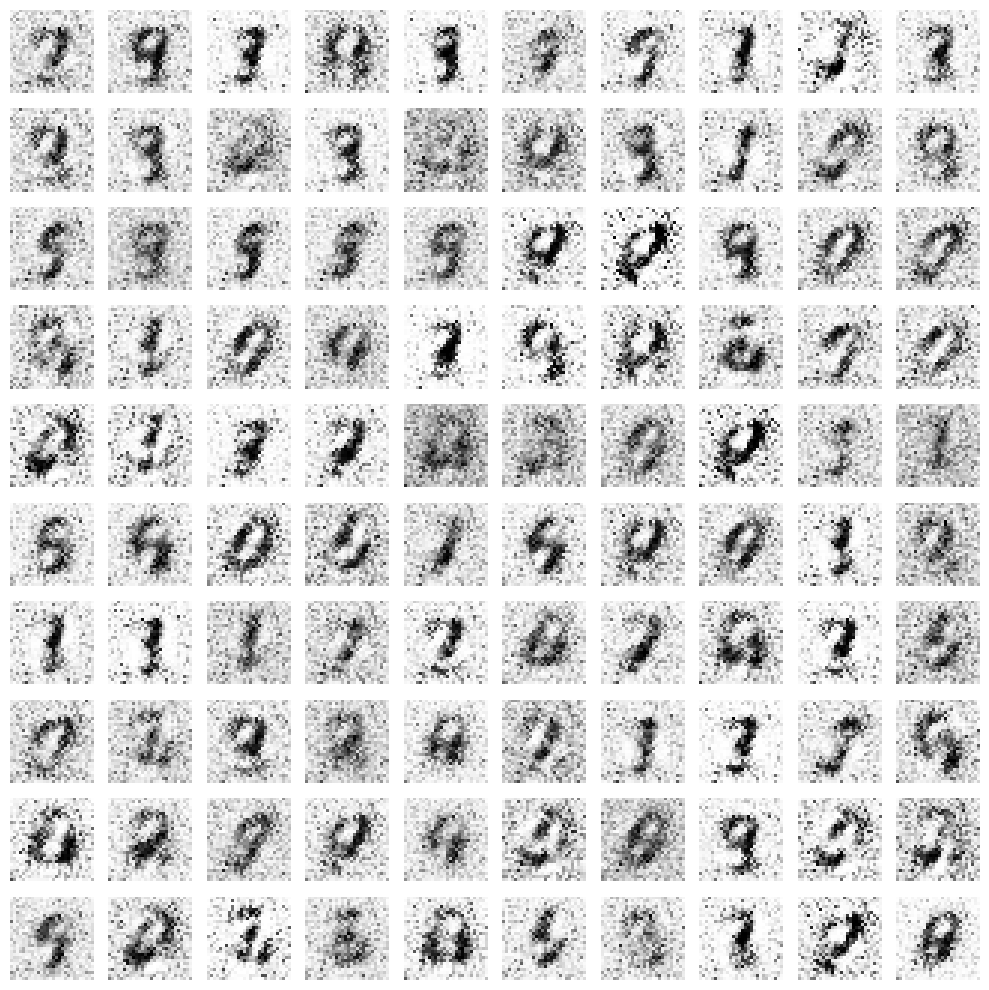

--------------- Epoch 2 ---------------
Batch 0/468: D loss: 0.5246, G loss: 1.3829
Batch 100/468: D loss: 0.5241, G loss: 1.4343
Batch 200/468: D loss: 0.5166, G loss: 1.5067
Batch 300/468: D loss: 0.5117, G loss: 1.5664
Batch 400/468: D loss: 0.5053, G loss: 1.6135
Epoch 2 completed: Discriminator Loss: 0.5023, Generator Loss: 1.6416
--------------- Epoch 3 ---------------
Batch 0/468: D loss: 0.5023, G loss: 1.6425
Batch 100/468: D loss: 0.4996, G loss: 1.6771
Batch 200/468: D loss: 0.4962, G loss: 1.7031
Batch 300/468: D loss: 0.4931, G loss: 1.7281
Batch 400/468: D loss: 0.4908, G loss: 1.7507
Epoch 3 completed: Discriminator Loss: 0.4887, Generator Loss: 1.7672
--------------- Epoch 4 ---------------
Batch 0/468: D loss: 0.4886, G loss: 1.7673
Batch 100/468: D loss: 0.4865, G loss: 1.7828
Batch 200/468: D loss: 0.4859, G loss: 1.7932
Batch 300/468: D loss: 0.4863, G loss: 1.7974
Batch 400/468: D loss: 0.4867, G loss: 1.7971
Epoch 4 completed: Discriminator Loss: 0.4859, Generator

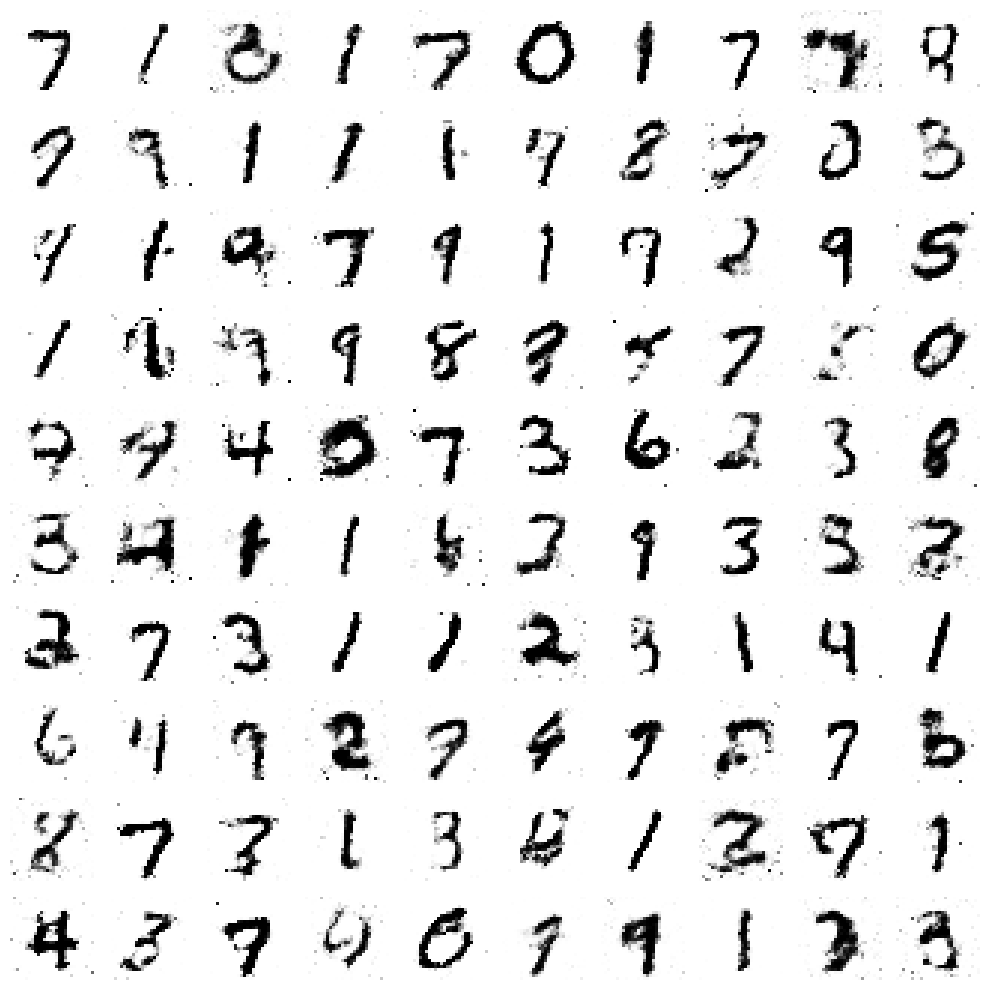

--------------- Epoch 21 ---------------
Batch 0/468: D loss: 0.5625, G loss: 1.3946
Batch 100/468: D loss: 0.5632, G loss: 1.3912
Batch 200/468: D loss: 0.5638, G loss: 1.3879
Batch 300/468: D loss: 0.5645, G loss: 1.3847
Batch 400/468: D loss: 0.5651, G loss: 1.3814
Epoch 21 completed: Discriminator Loss: 0.5656, Generator Loss: 1.3793
--------------- Epoch 22 ---------------
Batch 0/468: D loss: 0.5656, G loss: 1.3793
Batch 100/468: D loss: 0.5662, G loss: 1.3762
Batch 200/468: D loss: 0.5668, G loss: 1.3732
Batch 300/468: D loss: 0.5674, G loss: 1.3701
Batch 400/468: D loss: 0.5680, G loss: 1.3671
Epoch 22 completed: Discriminator Loss: 0.5684, Generator Loss: 1.3652
--------------- Epoch 23 ---------------
Batch 0/468: D loss: 0.5684, G loss: 1.3652
Batch 100/468: D loss: 0.5689, G loss: 1.3623
Batch 200/468: D loss: 0.5695, G loss: 1.3595
Batch 300/468: D loss: 0.5701, G loss: 1.3566
Batch 400/468: D loss: 0.5707, G loss: 1.3539
Epoch 23 completed: Discriminator Loss: 0.5710, Gen

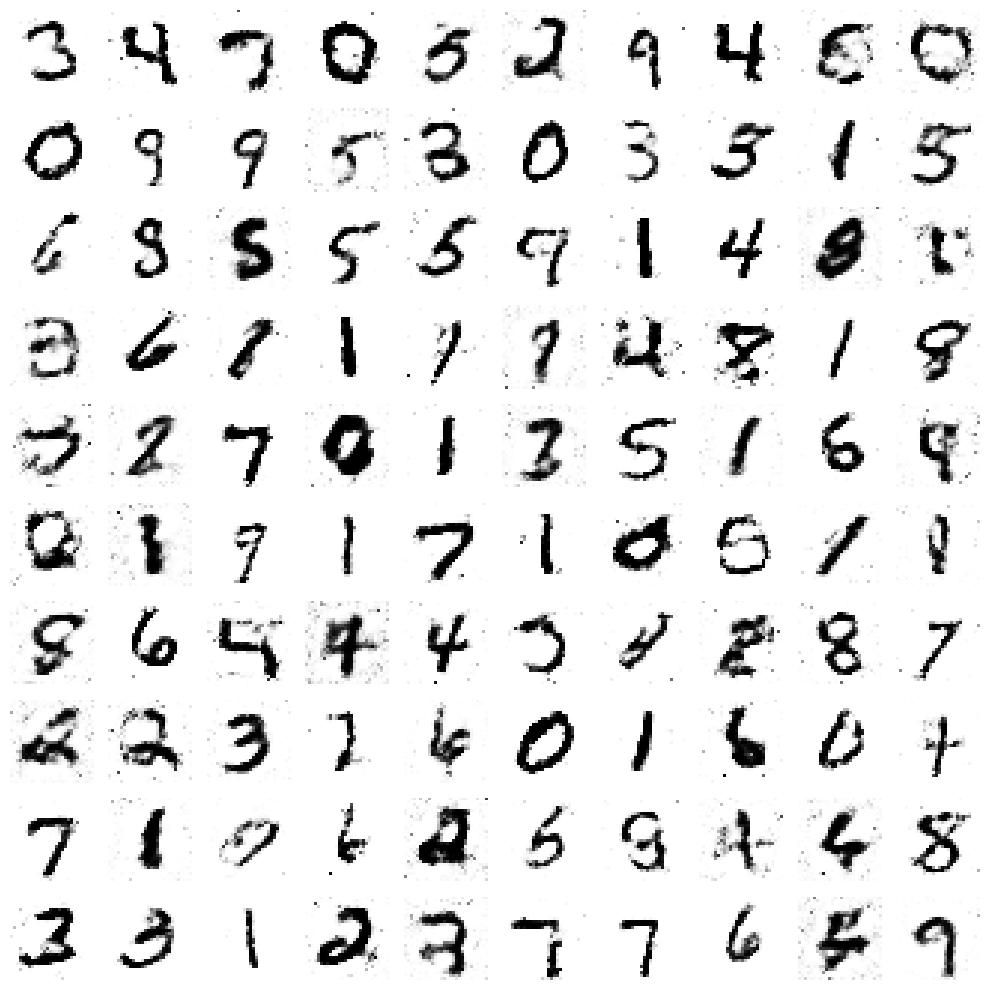

--------------- Epoch 41 ---------------
Batch 0/468: D loss: 0.5980, G loss: 1.2187
Batch 100/468: D loss: 0.5982, G loss: 1.2177
Batch 200/468: D loss: 0.5984, G loss: 1.2167
Batch 300/468: D loss: 0.5987, G loss: 1.2157
Batch 400/468: D loss: 0.5989, G loss: 1.2147
Epoch 41 completed: Discriminator Loss: 0.5990, Generator Loss: 1.2140
--------------- Epoch 42 ---------------
Batch 0/468: D loss: 0.5990, G loss: 1.2140
Batch 100/468: D loss: 0.5992, G loss: 1.2130
Batch 200/468: D loss: 0.5994, G loss: 1.2120
Batch 300/468: D loss: 0.5996, G loss: 1.2110
Batch 400/468: D loss: 0.5998, G loss: 1.2100
Epoch 42 completed: Discriminator Loss: 0.6000, Generator Loss: 1.2093
--------------- Epoch 43 ---------------
Batch 0/468: D loss: 0.6000, G loss: 1.2093
Batch 100/468: D loss: 0.6002, G loss: 1.2084
Batch 200/468: D loss: 0.6003, G loss: 1.2074
Batch 300/468: D loss: 0.6005, G loss: 1.2065
Batch 400/468: D loss: 0.6007, G loss: 1.2056
Epoch 43 completed: Discriminator Loss: 0.6009, Gen

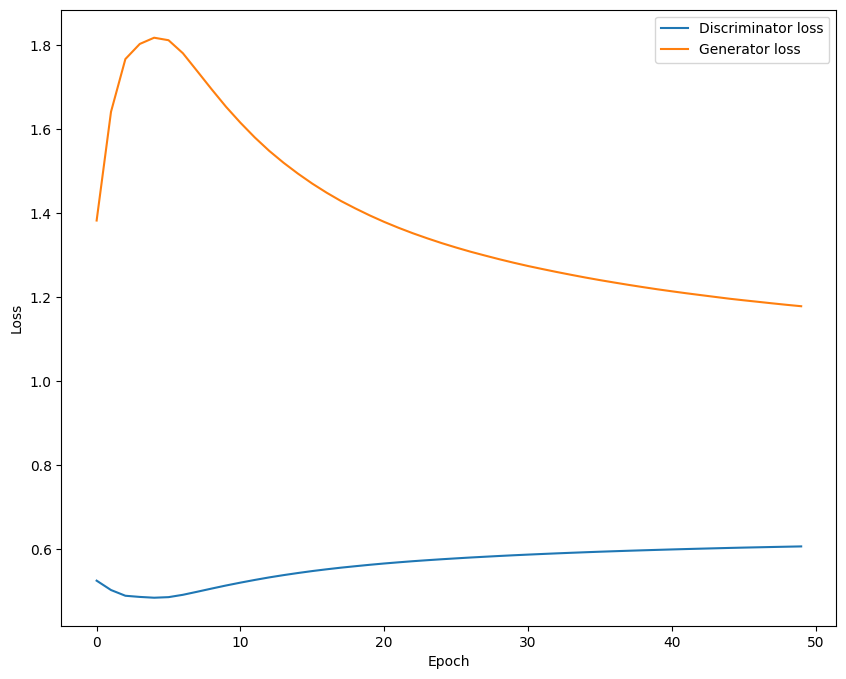

--------------- Epoch 51 ---------------
Batch 0/468: D loss: 0.6062, G loss: 1.1784
Batch 100/468: D loss: 0.6064, G loss: 1.1777
Batch 200/468: D loss: 0.6065, G loss: 1.1770
Batch 300/468: D loss: 0.6067, G loss: 1.1763
Batch 400/468: D loss: 0.6068, G loss: 1.1756
Epoch 51 completed: Discriminator Loss: 0.6069, Generator Loss: 1.1751
--------------- Epoch 52 ---------------
Batch 0/468: D loss: 0.6069, G loss: 1.1751
Batch 100/468: D loss: 0.6070, G loss: 1.1744
Batch 200/468: D loss: 0.6072, G loss: 1.1737
Batch 300/468: D loss: 0.6073, G loss: 1.1732
Batch 400/468: D loss: 0.6074, G loss: 1.1725
Epoch 52 completed: Discriminator Loss: 0.6075, Generator Loss: 1.1720
--------------- Epoch 53 ---------------
Batch 0/468: D loss: 0.6075, G loss: 1.1720
Batch 100/468: D loss: 0.6076, G loss: 1.1713
Batch 200/468: D loss: 0.6078, G loss: 1.1707
Batch 300/468: D loss: 0.6079, G loss: 1.1701
Batch 400/468: D loss: 0.6080, G loss: 1.1694
Epoch 53 completed: Discriminator Loss: 0.6081, Gen

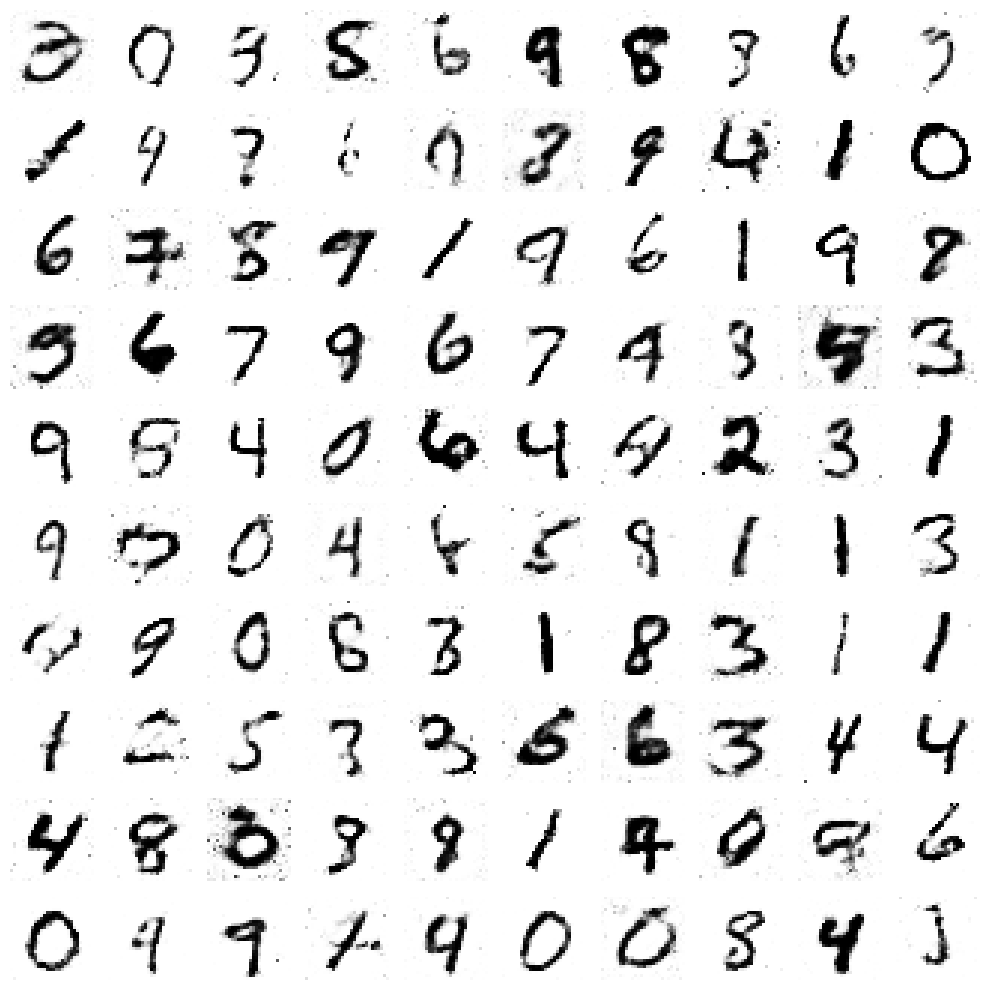

--------------- Epoch 61 ---------------
Batch 0/468: D loss: 0.6117, G loss: 1.1509
Batch 100/468: D loss: 0.6118, G loss: 1.1504
Batch 200/468: D loss: 0.6119, G loss: 1.1499
Batch 300/468: D loss: 0.6120, G loss: 1.1494
Batch 400/468: D loss: 0.6121, G loss: 1.1489
Epoch 61 completed: Discriminator Loss: 0.6122, Generator Loss: 1.1486
--------------- Epoch 62 ---------------
Batch 0/468: D loss: 0.6122, G loss: 1.1486
Batch 100/468: D loss: 0.6123, G loss: 1.1481
Batch 200/468: D loss: 0.6124, G loss: 1.1476
Batch 300/468: D loss: 0.6125, G loss: 1.1471
Batch 400/468: D loss: 0.6125, G loss: 1.1466
Epoch 62 completed: Discriminator Loss: 0.6126, Generator Loss: 1.1463
--------------- Epoch 63 ---------------
Batch 0/468: D loss: 0.6126, G loss: 1.1463
Batch 100/468: D loss: 0.6127, G loss: 1.1458
Batch 200/468: D loss: 0.6128, G loss: 1.1453
Batch 300/468: D loss: 0.6129, G loss: 1.1449
Batch 400/468: D loss: 0.6130, G loss: 1.1444
Epoch 63 completed: Discriminator Loss: 0.6130, Gen

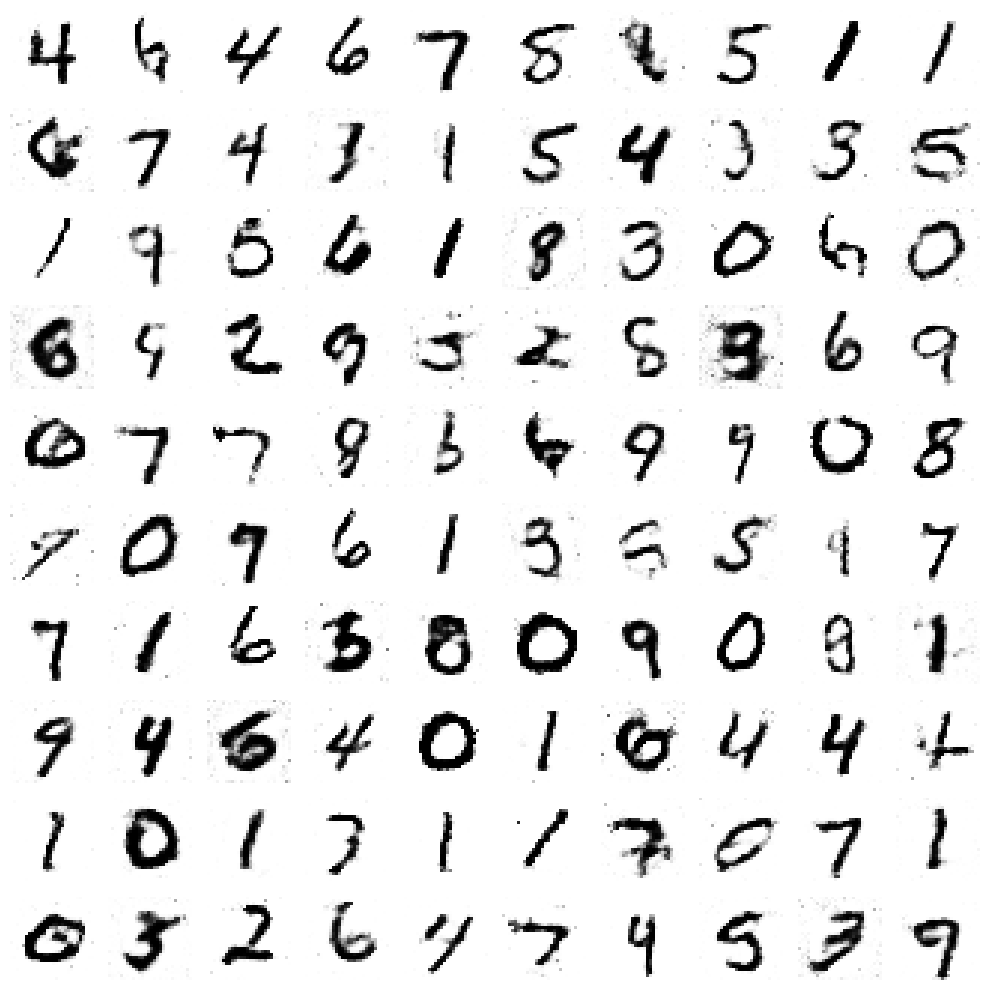

--------------- Epoch 81 ---------------
Batch 0/468: D loss: 0.6185, G loss: 1.1157
Batch 100/468: D loss: 0.6186, G loss: 1.1154
Batch 200/468: D loss: 0.6186, G loss: 1.1151
Batch 300/468: D loss: 0.6187, G loss: 1.1149
Batch 400/468: D loss: 0.6187, G loss: 1.1146
Epoch 81 completed: Discriminator Loss: 0.6188, Generator Loss: 1.1144
--------------- Epoch 82 ---------------
Batch 0/468: D loss: 0.6188, G loss: 1.1144
Batch 100/468: D loss: 0.6188, G loss: 1.1141
Batch 200/468: D loss: 0.6189, G loss: 1.1139
Batch 300/468: D loss: 0.6189, G loss: 1.1136
Batch 400/468: D loss: 0.6190, G loss: 1.1133
Epoch 82 completed: Discriminator Loss: 0.6190, Generator Loss: 1.1132
--------------- Epoch 83 ---------------
Batch 0/468: D loss: 0.6190, G loss: 1.1131
Batch 100/468: D loss: 0.6191, G loss: 1.1129
Batch 200/468: D loss: 0.6191, G loss: 1.1126
Batch 300/468: D loss: 0.6192, G loss: 1.1123
Batch 400/468: D loss: 0.6192, G loss: 1.1121
Epoch 83 completed: Discriminator Loss: 0.6193, Gen

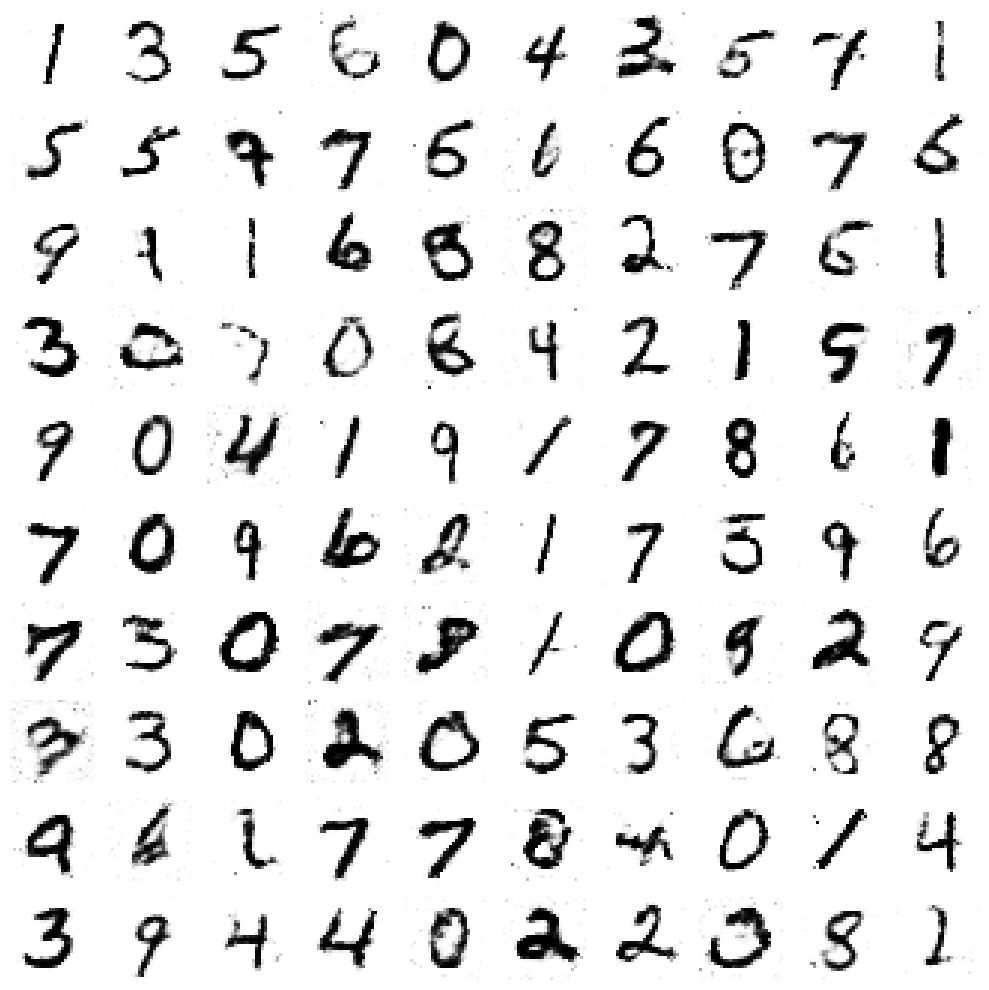

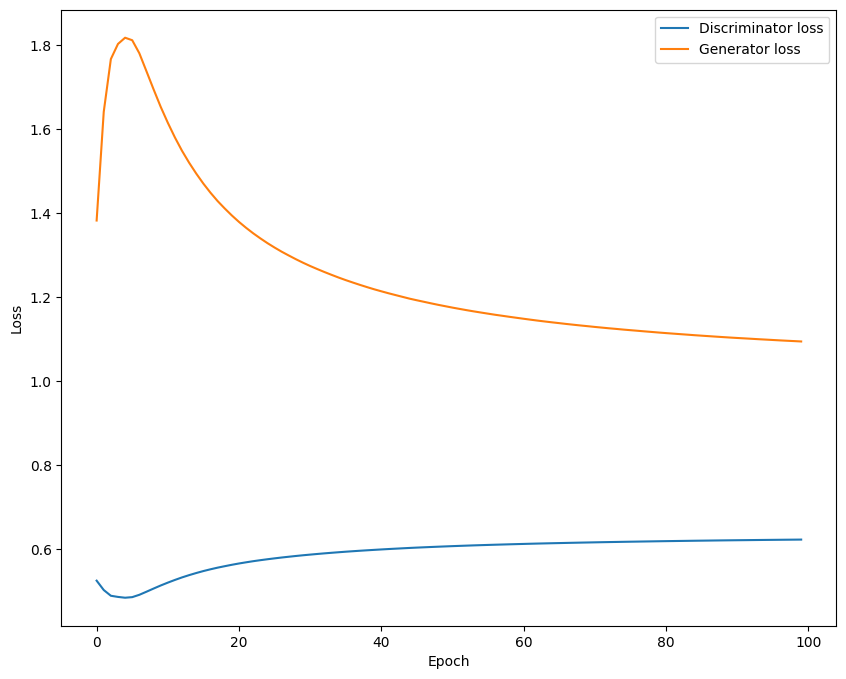

Generating final images...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


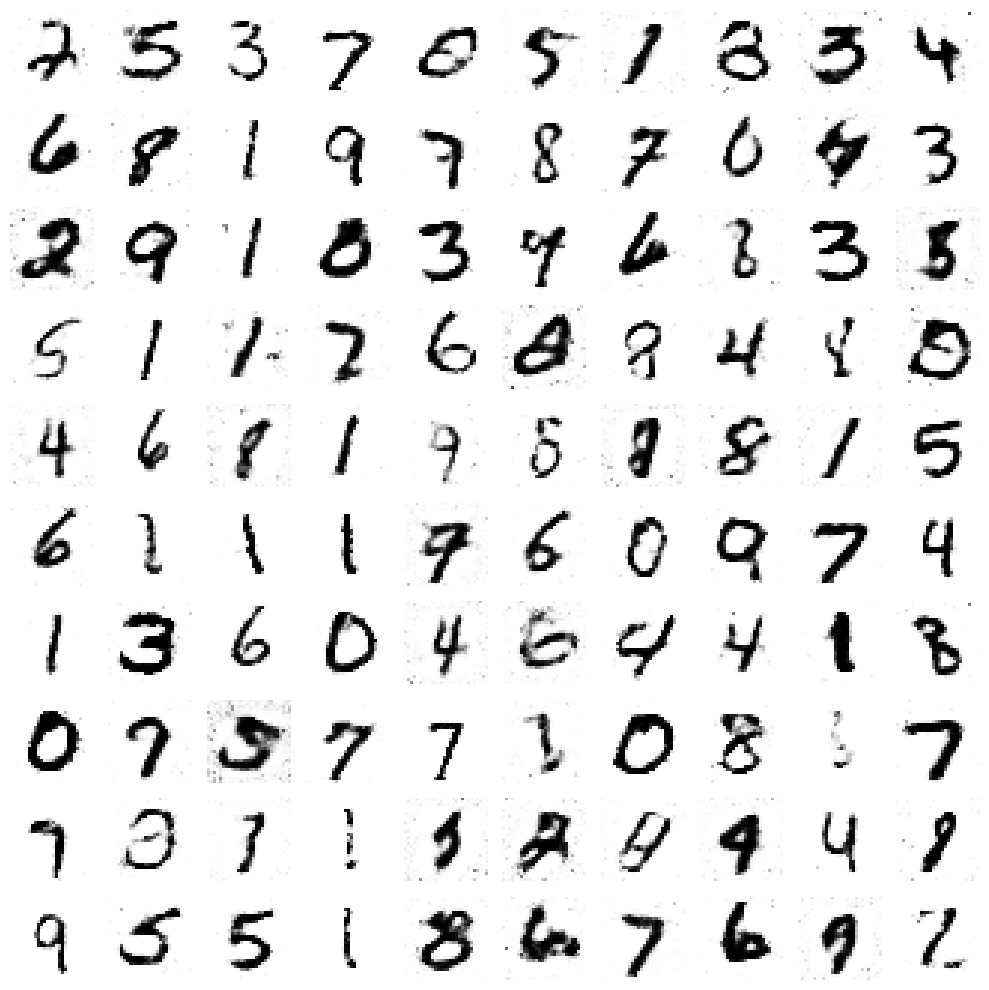

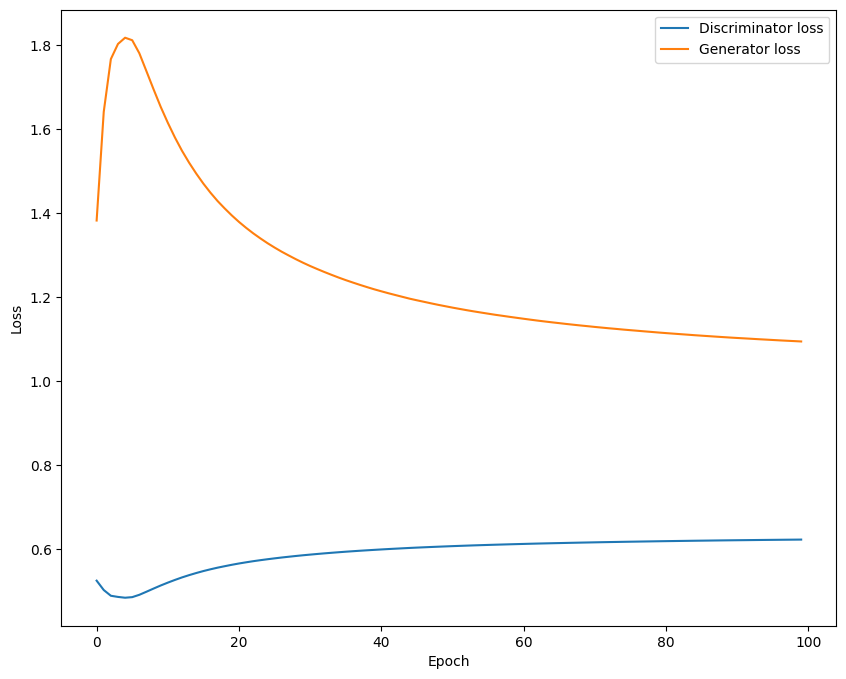

In [5]:
#Quick test before training
print("\nTesting model structure...")

#Generate a single random noise vector (1 sample, 100-dim)
test_noise = np.random.normal(0, 1, size=[1, randomDim])

#Pass noise through generator to create one fake image
test_generated = generator.predict(test_noise)

#Pass the fake image through discriminator to get "real vs fake" probability
test_discrimination = discriminator.predict(test_generated)

#Print results: shape of generated image and discriminator output
print(f"Test successful! Generated image shape: {test_generated.shape}, "
      f"Discrimination output: {test_discrimination}")

#Begin training the GAN
print("\nStarting GAN training...")
#Train for 100 epochs with batch size of 128
#Each epoch consists of alternating updates of discriminator and generator
train(epochs=100, batchSize=128)



#Generate final outputs after training
print("Generating final images...")

#Save a grid of final generated digits
saveGeneratedImages('final')

#Plot the loss curves of generator vs discriminator
plotLoss('final')
